In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.gridspec import GridSpec
from astropy.io import fits
from astropy import wcs
from astropy.table import Table
from astropy.cosmology import Planck15 as cosmo
import astropy.units as u
from pandas import DataFrame

import seaborn as sea
%matplotlib inline

In [2]:
table_path = '../tables/'
cat_path = '../CANDLES_data/goods_catalogs/'
total_path = '../total_gal/'
cutout_path = '../CANDLES_data/total_cutouts/'
save_cutout_path = '../CANDLES_data/merger_cutouts/'

### Scaling Factor
This function takes in the total counts of a galaxy, along with the minimum and maximum values desired and it replaces any value above the maximum value with itself, samething with the minimum. This functions main use is to remove any faulty pixels.

In [3]:
#Functions
#--------------------------------------------------Scaling Factor-------------------------------------------------------
def Scaling_factor(X, m, M):              #X = Counts, m = Vmin, M = Vmax
    m_mask = np.zeros_like(X)
    M_mask = np.zeros_like(X)

    for i in range(len(X)):
        for ii in range(len(X[0])):
            if X[i][ii] <= m:
                m_mask[i][ii] = 1 
            
            if X[i][ii] >= M:
                M_mask[i][ii] = 1 
             
    scl_img =  np.arcsinh(X - m)/np.arcsinh(M - m)
            
    for i in range(len(X)):
        for ii in range(len(X[0])):
            if m_mask[i][ii] == 1:
                scl_img[i][ii] = 0
            if M_mask[i][ii] == 1:
                scl_img[i][ii] = 1
            
    return scl_img

## First round of merger candidates
This is our first attempt to detect galaxy mergers by determining if any galaxy is within 44.3 kila parsecs from each other (in ra, dec, or redshift).

In [159]:
#Original Code

Sections = ['GN1', 'GN2', 'GN3', 'GN4', 'GN5', 'GN7', 'GS1', 'GS2', 'GS3', 'GS4', 'GS5', 'ERSPRIME']               

Merger_dict = {'GN1':[], 'GN2':[], 'GN3':[], 'GN4':[], 'GN5':[], 'GN7':[], 
              'GS1':[], 'GS2':[], 'GS3':[], 'GS4':[], 'GS5':[], 'ERSPRIME':[],
              'GN1_ra':[], 'GN2_ra':[], 'GN3_ra':[], 'GN4_ra':[], 'GN5_ra':[], 'GN7_ra':[],
              'GS1_ra':[], 'GS2_ra':[], 'GS3_ra':[], 'GS4_ra':[], 'GS5_ra':[], 'ERSPRIME_ra':[],
              'GN1_dec':[], 'GN2_dec':[], 'GN3_dec':[], 'GN4_dec':[], 'GN5_dec':[], 'GN7_dec':[],
              'GS1_dec':[], 'GS2_dec':[], 'GS3_dec':[], 'GS4_dec':[], 'GS5_dec':[], 'ERSPRIME_dec':[],
              'GN1_z':[], 'GN2_z':[], 'GN3_z':[], 'GN4_z':[], 'GN5_z':[], 'GN7_z':[],
              'GS1_z':[], 'GS2_z':[], 'GS3_z':[], 'GS4_z':[], 'GS5_z':[], 'ERSPRIME_z':[],
              'GN1_merge':[], 'GN2_merge':[], 'GN3_merge':[], 'GN4_merge':[], 'GN5_merge':[], 'GN7_merge':[], 
              'GS1_merge':[], 'GS2_merge':[], 'GS3_merge':[], 'GS4_merge':[], 'GS5_merge':[], 'ERSPRIME_merge':[],
              'GN1_nearby':[], 'GN2_nearby':[], 'GN3_nearby':[], 'GN4_nearby':[], 'GN5_nearby':[], 'GN7_nearby':[],
              'GS1_nearby':[], 'GS2_nearby':[], 'GS3_nearby':[], 'GS4_nearby':[], 'GS5_nearby':[], 'ERSPRIME_nearby':[]}

for i in Sections:
    Test_Subjects = np.loadtxt(total_path+'{}_total.txt'.format(i)).astype(int)
    
    if i[1] == 'N':
        cat = Table.read(fits.open(cat_path+'goodsn_3dhst.v4.4.zout.fits'), format = 'fits').to_pandas()
    else:
        cat = Table.read(fits.open(cat_path+'goodss_3dhst.v4.4.zout.fits'), format = 'fits').to_pandas()

    for ii in Test_Subjects:
        Merger_dict[i].append(ii)
        Merger_dict['{}_ra'.format(i)].append(cat.query('id == {}'.format(ii)).ra.values[0])
        Merger_dict['{}_dec'.format(i)].append(cat.query('id == {}'.format(ii)).dec.values[0])
        Merger_dict['{}_z'.format(i)].append(cat.query('id == {}'.format(ii)).z500.values[0])

In [160]:
#Original Code

Sections = ['GN1', 'GN2', 'GN3', 'GN4', 'GN5', 'GN7', 'GS1', 'GS2', 'GS3', 'GS4', 'GS5', 'ERSPRIME']
#Sections = ['ERSPRIME', 'GN1', 'GN3', 'GN4']                 

for i in Sections:   
    if i[1] == 'N':
        cat = Table.read( fits.open(cat_path+'goodsn_3dhst.v4.4.zout.fits'), 
                         format = 'fits').to_pandas()
    else:
        cat = Table.read(fits.open(cat_path+'goodss_3dhst.v4.4.zout.fits'), 
                         format = 'fits').to_pandas()
    
    for ii in range(len(Merger_dict['{}_ra'.format(i)])):
        ra = Merger_dict['{}_ra'.format(i)][ii]
        dec = Merger_dict['{}_dec'.format(i)][ii]
        z = Merger_dict['{}_z'.format(i)][ii]


        diff_ra = np.abs(ra - cat['ra'].values)
        diff_dec = np.abs(dec - cat['dec'].values)
        diff_z = np.abs(z - cat['z500'].values) / (1 + cat['z500'].values)

        diff_ra_kpc = (1/cosmo.arcsec_per_kpc_proper(z)) * diff_ra*u.deg * 60**2*u.arcsec / u.deg
        diff_dec_kpc = (1/cosmo.arcsec_per_kpc_proper(z)) * diff_dec*u.deg * 60**2*u.arcsec / u.deg
        
        z_pass = cat['id'].values[diff_z < 0.06]
        ra_pass = cat['id'].values[diff_ra_kpc.value < 44.3]
        dec_pass = cat['id'].values[diff_dec_kpc.value < 44.3]

        mergers = []
        
        for RA in ra_pass:
            if RA in dec_pass and RA in z_pass and RA != Merger_dict[i][ii]:
                mergers.append(RA)
        Merger_dict['{}_merge'.format(i)].append(mergers)

## Saving our data
This saves all our initial mergers into individual csv files for our fields in GOODS North and GOODS South

In [16]:
#MAKING A PANDAS DICTIONARY
#GN1
GN1_data =  {'ids': pd.Series(Merger_dict['GN1']), 'ra': pd.Series(Merger_dict['GN1_ra']), 
              'dec': pd.Series(Merger_dict['GN1_dec']),'z': pd.Series(Merger_dict['GN1_z']), 
              'mergers': pd.Series(Merger_dict['GN1_merge'])}
GN1_table = pd.DataFrame(GN1_data)
#GN2
GN2_data =  {'ids': pd.Series(Merger_dict['GN2']), 'ra': pd.Series(Merger_dict['GN2_ra']), 
              'dec': pd.Series(Merger_dict['GN2_dec']),'z': pd.Series(Merger_dict['GN2_z']), 
              'mergers': pd.Series(Merger_dict['GN2_merge'])}
GN2_table = pd.DataFrame(GN2_data)
#GN3
GN3_data =  {'ids': pd.Series(Merger_dict['GN3']), 'ra': pd.Series(Merger_dict['GN3_ra']), 
              'dec': pd.Series(Merger_dict['GN3_dec']),'z': pd.Series(Merger_dict['GN3_z']), 
              'mergers': pd.Series(Merger_dict['GN3_merge'])}
GN3_table = pd.DataFrame(GN3_data)
#GN4
GN4_data =  {'ids': pd.Series(Merger_dict['GN4']), 'ra': pd.Series(Merger_dict['GN4_ra']), 
              'dec': pd.Series(Merger_dict['GN4_dec']),'z': pd.Series(Merger_dict['GN4_z']), 
              'mergers': pd.Series(Merger_dict['GN4_merge'])}
GN4_table = pd.DataFrame(GN4_data)
#GN5
GN5_data =  {'ids': pd.Series(Merger_dict['GN5']), 'ra': pd.Series(Merger_dict['GN5_ra']), 
              'dec': pd.Series(Merger_dict['GN5_dec']),'z': pd.Series(Merger_dict['GN5_z']), 
              'mergers': pd.Series(Merger_dict['GN5_merge'])}
GN5_table = pd.DataFrame(GN5_data)
#GN7
GN7_data =  {'ids': pd.Series(Merger_dict['GN7']), 'ra': pd.Series(Merger_dict['GN7_ra']), 
              'dec': pd.Series(Merger_dict['GN7_dec']),'z': pd.Series(Merger_dict['GN7_z']), 
              'mergers': pd.Series(Merger_dict['GN7_merge'])}
GN7_table = pd.DataFrame(GN7_data)
#GS1
GS1_data =  {'ids': pd.Series(Merger_dict['GS1']), 'ra': pd.Series(Merger_dict['GS1_ra']), 
              'dec': pd.Series(Merger_dict['GS1_dec']),'z': pd.Series(Merger_dict['GS1_z']), 
              'mergers': pd.Series(Merger_dict['GS1_merge'])}
GS1_table = pd.DataFrame(GS1_data)
#GS2
GS2_data =  {'ids': pd.Series(Merger_dict['GS2']), 'ra': pd.Series(Merger_dict['GS2_ra']), 
              'dec': pd.Series(Merger_dict['GS2_dec']),'z': pd.Series(Merger_dict['GS2_z']), 
              'mergers': pd.Series(Merger_dict['GS2_merge'])}
GS2_table = pd.DataFrame(GS2_data)
#GS3
GS3_data =  {'ids': pd.Series(Merger_dict['GS3']), 'ra': pd.Series(Merger_dict['GS3_ra']), 
              'dec': pd.Series(Merger_dict['GS3_dec']),'z': pd.Series(Merger_dict['GS3_z']), 
              'mergers': pd.Series(Merger_dict['GS3_merge'])}
GS3_table = pd.DataFrame(GS3_data)
#GS4
GS4_data =  {'ids': pd.Series(Merger_dict['GS4']), 'ra': pd.Series(Merger_dict['GS4_ra']), 
              'dec': pd.Series(Merger_dict['GS4_dec']),'z': pd.Series(Merger_dict['GS4_z']), 
              'mergers': pd.Series(Merger_dict['GS4_merge'])}
GS4_table = pd.DataFrame(GS4_data)
#GS5
GS5_data =  {'ids': pd.Series(Merger_dict['GS5']), 'ra': pd.Series(Merger_dict['GS5_ra']), 
              'dec': pd.Series(Merger_dict['GS5_dec']),'z': pd.Series(Merger_dict['GS5_z']), 
              'mergers': pd.Series(Merger_dict['GS5_merge'])}
GS5_table = pd.DataFrame(GS5_data)
#ERSPRIME
ERSPRIME_data =  {'ids': pd.Series(Merger_dict['ERSPRIME']), 'ra': pd.Series(Merger_dict['ERSPRIME_ra']), 
              'dec': pd.Series(Merger_dict['ERSPRIME_dec']),'z': pd.Series(Merger_dict['ERSPRIME_z']), 
              'mergers': pd.Series(Merger_dict['ERSPRIME_merge'])}
ERSPRIME_table = pd.DataFrame(ERSPRIME_data)

# uncomment to save
#GN1_table.to_csv(table_path+'GN1_data.csv')
#GN2_table.to_csv(table_path+'GN2_data.csv')
#GN3_table.to_csv(table_path+'GN3_data.csv')
#GN4_table.to_csv(table_path+'GN4_data.csv')
#GN5_table.to_csv(table_path+'GN5_data.csv')
#GN7_table.to_csv(table_path+'GN7_data.csv')
#GS1_table.to_csv(table_path+'GS1_data.csv')
#GS2_table.to_csv(table_path+'GS2_data.csv')
#GS3_table.to_csv(table_path+'GS3_data.csv')
#GS4_table.to_csv(table_path+'GS4_data.csv')
#GS5_table.to_csv(table_path+'GS5_data.csv')
#ERSPRIME_table.to_csv(table_path+'ERSPRIME_data.csv')

In [17]:
GN1_table.head()

,ids,ra,dec,z,mergers
0,35921,189.317776,62.333192,1.139503,[]
1,37037,189.287029,62.345864,1.554765,[]
2,37382,189.290368,62.351979,3.984069,[]
3,37590,189.296412,62.357283,1.235418,[]
4,37786,189.281986,62.363756,1.497277,"[37738, 37836]"


As can be seen by examining GN1, the first 4 galaxies have no mergers while the fourth galaxy (GN1 37786) is tagged with merging other galaxies.

In [83]:
np.array(Merger_dict[field+'_merge'][4]),gal_ids

(array([37738, 37836]), 37786)

In [90]:
# The field we are observing
field = 'GN1'

# pulling the ID's and mergers of our field
gal_ids = np.array([Merger_dict[field][4]])
mergers = np.array(Merger_dict[field+'_merge'][4])
gal_mergers = np.concatenate((mergers,gal_ids))

/Users/felix/anaconda3/envs/grizli/lib/python3.6/site-packages/ipykernel_launcher.py:35: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


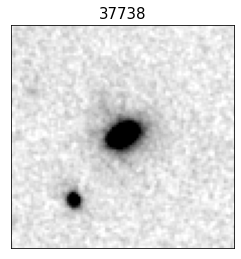

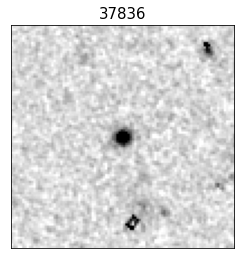

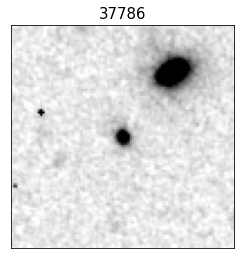

In [93]:
# The field and galaxy we are observing
field = 'GN1'
idx = 4

# pulling the ID's and mergers of our field
gal_ids = np.array([Merger_dict[field][idx]])
mergers = np.array(Merger_dict[field+'_merge'][idx])
gal_mergers = np.concatenate((mergers,gal_ids))

Temp_id = []
RealData_id = []

Temp_merge = []
RealData_merge = []

# We are going to be printing out the cutouts of each of the galaxies that are being detected by a merge
for i in range(len(gal_mergers)):
    id = gal_mergers[i]
    gs = GridSpec(1,2, wspace = 0, hspace=0)
    plt.figure(figsize=[8,10])
    
    GN_img = np.load(cutout_path+'{}/{}_{}_F105W.npy'.format(field,field,id))
        
    m=np.percentile(GN_img,1.5)
    M=np.percentile(GN_img,98.5)
    if M < np.abs(m)*6:
        M = np.abs(m)*6        
    if np.sum(GN_img) == 0:
        pass
    else:
        Temp_id.append(GN_img)
        RealData_id.append(Scaling_factor(GN_img, m, M))
            
    for j in range(len(Temp_id)):
        plt.subplot(gs[0,0])
        plt.subplots_adjust(wspace=.1)
        plt.title(gal_mergers[j], fontsize = 15)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(RealData_id[j],vmin= 0, vmax = 1, cmap='binary')

        plt.savefig(save_cutout_path+'/GN1_{}.png'.format(gal_mergers[j]), bbox_inches = 'tight')

# Trying to Impliment all Galaxies

In [138]:
#Testing all Galaxies

Sections = ['GN1', 'GN2', 'GN3', 'GN4', 'GN5', 'GN7', 'GS1', 'GS2', 'GS3', 'GS4', 'GS5', 'ERSPRIME']
#Sections = ['GN1']

Merger_dict = {'GN1':[], 'GN2':[], 'GN3':[], 'GN4':[], 'GN5':[], 'GN7':[], 
              'GS1':[], 'GS2':[], 'GS3':[], 'GS4':[], 'GS5':[], 'ERSPRIME':[],
              'GN1_ra':[], 'GN2_ra':[], 'GN3_ra':[], 'GN4_ra':[], 'GN5_ra':[], 'GN7_ra':[],
              'GS1_ra':[], 'GS2_ra':[], 'GS3_ra':[], 'GS4_ra':[], 'GS5_ra':[], 'ERSPRIME_ra':[],
              'GN1_dec':[], 'GN2_dec':[], 'GN3_dec':[], 'GN4_dec':[], 'GN5_dec':[], 'GN7_dec':[],
              'GS1_dec':[], 'GS2_dec':[], 'GS3_dec':[], 'GS4_dec':[], 'GS5_dec':[], 'ERSPRIME_dec':[],
              'GN1_z':[], 'GN2_z':[], 'GN3_z':[], 'GN4_z':[], 'GN5_z':[], 'GN7_z':[],
              'GS1_z':[], 'GS2_z':[], 'GS3_z':[], 'GS4_z':[], 'GS5_z':[], 'ERSPRIME_z':[],
              'GN1_nearby':[], 'GN2_nearby':[], 'GN3_nearby':[], 'GN4_nearby':[], 'GN5_nearby':[], 'GN7_nearby':[],
              'GS1_nearby':[], 'GS2_nearby':[], 'GS3_nearby':[], 'GS4_nearby':[], 'GS5_nearby':[], 'ERSPRIME_nearby':[],
              'GN1_merge':[], 'GN2_merge':[], 'GN3_merge':[], 'GN4_merge':[], 'GN5_merge':[], 'GN7_merge':[], 
              'GS1_merge':[], 'GS2_merge':[], 'GS3_merge':[], 'GS4_merge':[], 'GS5_merge':[], 'ERSPRIME_merge':[],
              'GN1_new_z':[], 'GN2_new_z':[], 'GN3_new_z':[], 'GN4_new_z':[], 'GN5_new_z':[], 'GN7_new_z':[], 
              'GS1_new_z':[], 'GS2_new_z':[], 'GS3_new_z':[], 'GS4_new_z':[], 'GS5_new_z':[], 'ERSPRIME_new_z':[],}

for i in Sections:
    Test_Subjects = np.loadtxt(total_path+'{}_total.txt'.format(i)).astype(int)
    
    if i[1] == 'N':
        cat = Table.read( fits.open(cat_path+'goodsn_3dhst.v4.4.zout.fits'), 
                         format = 'fits').to_pandas()
    else:
        cat = Table.read(fits.open(cat_path+'goodss_3dhst.v4.4.zout.fits'), 
                         format = 'fits').to_pandas()

    for ii in Test_Subjects:
        Merger_dict[i].append(ii)
        Merger_dict['{}_ra'.format(i)].append(cat.query('id == {}'.format(ii)).ra.values[0])
        Merger_dict['{}_dec'.format(i)].append(cat.query('id == {}'.format(ii)).dec.values[0])
        Merger_dict['{}_z'.format(i)].append(cat.query('id == {}'.format(ii)).z500.values[0])

# Deleting Empty Arrays

In [162]:
#Deleting Empty Blocks

#Sections = ['GN1', 'GN2', 'GN3', 'GN4', 'GN5', 'GN7', 'GS1', 'GS2', 'GS3', 'GS4', 'GS5', 'ERSPRIME']
Sections = ['ERSPRIME', 'GN1', 'GN3', 'GN4']
Sections = ['GN1']

for i in Sections:
    print(i)
    for j in range(len(Merger_dict['{}_merge'.format(i)])):
        if Merger_dict['{}_merge'.format(i)] != []:
            Merger_dict['{}_nearby'.format(i)].append(Merger_dict['{}_merge'.format(i)])
        else:
            pass;

GN1


In [151]:
#Deleting Empty Blocks

#Sections = ['GN1', 'GN2', 'GN3', 'GN4', 'GN5', 'GN7', 'GS1', 'GS2', 'GS3', 'GS4', 'GS5', 'ERSPRIME']
Sections = ['ERSPRIME', 'GN1', 'GN3', 'GN4']

for i in Sections:
    print(i)
    for ii in range(len(Merger_dict['{}_merge'.format(i)])):
        print(Merger_dict['{}_merge'.format(i)])
        if Merger_dict['{}_merge'.format(i)] != []:
            Merger_dict['{}_nearby'.format(i)].append(Merger_dict['{}_merge'.format(i)]);
        else:
            pass;

ERSPRIME
GN1
GN3
GN4


In [142]:
Merger_dict['GN1_merge']

[]

# Narrowing Down Z

In [99]:
#Z Test

#Sections = ['GN1', 'GN2', 'GN3', 'GN4', 'GN5', 'GN7', 'GS1', 'GS2', 'GS3', 'GS4', 'GS5', 'ERSPRIME']
#Sections = ['GN1']

for i in Sections:
    if i[1] == 'N':
        cat = Table.read( fits.open(cat_path+'/goodsn_3dhst.v4.4.zout.fits'), 
                         format = 'fits').to_pandas()
    else:
        cat = Table.read(fits.open(cat_path+'/goodss_3dhst.v4.4.zout.fits'), 
                         format = 'fits').to_pandas()
            
    z_range = []
    

    for j in range(len(Merger_dict['{}_z'.format(i)])):
        z = Merger_dict['{}_z'.format(i)][j]
        if z > 2.3 or z < .2:
            pass;
        else:
            z_range.append(z)

In [107]:
#Z Test in Action

Sections = ['GN1', 'GN2', 'GN3', 'GN4', 'GN5', 'GN7', 'GS1', 'GS2', 'GS3', 'GS4', 'GS5', 'ERSPRIME']
#Sections = ['GN1']

for i in Sections:   
    if i[1] == 'N':
        cat = Table.read( fits.open(cat_path+'goodsn_3dhst.v4.4.zout.fits'), 
                         format = 'fits').to_pandas()
    else:
        cat = Table.read(fits.open(cat_path+'goodss_3dhst.v4.4.zout.fits'), 
                         format = 'fits').to_pandas()
    
    z_range = []

    for ii in range(len(Merger_dict['{}_z'.format(i)])):
        z = Merger_dict['{}_z'.format(i)][ii]
        if z > 2.3 or z < .2:
            pass;
        else:
            zz = Merger_dict['{}_new_z'.format(i)].append(z)
            ra = Merger_dict['{}_ra'.format(i)][ii]
            dec = Merger_dict['{}_dec'.format(i)][ii]
            diff_ra = np.abs(ra - cat['ra'].values)
            diff_dec = np.abs(dec - cat['dec'].values)
            diff_z = np.abs(z - cat['z500'].values)

            diff_ra_kpc = (1/cosmo.arcsec_per_kpc_proper(z)) * diff_ra*u.deg * 60**2*u.arcsec / u.deg
            diff_dec_kpc = (1/cosmo.arcsec_per_kpc_proper(z)) * diff_dec*u.deg * 60**2*u.arcsec / u.deg
        
            z_pass = cat['id'].values[diff_z < 0.1]
            ra_pass = cat['id'].values[diff_ra_kpc.value < 44.3]
            dec_pass = cat['id'].values[diff_dec_kpc.value < 44.3]
                
    #for ii in range(len(Merger_dict['{}_z'.format(i)])):
        
            
        #ra = Merger_dict['{}_ra'.format(i)][ii]
        #dec = Merger_dict['{}_dec'.format(i)][ii]
        #z = Merger_dict['{}_z'.format(i)][ii]
        #z = Merger_dict['{}_new_z'.format(i)][ii]
        
        #diff_ra = np.abs(ra - cat['ra'].values)
        #diff_dec = np.abs(dec - cat['dec'].values)
        #diff_z = np.abs(z - cat['z500'].values)

        #diff_ra_kpc = (1/cosmo.arcsec_per_kpc_proper(z)) * diff_ra*u.deg * 60**2*u.arcsec / u.deg
        #diff_dec_kpc = (1/cosmo.arcsec_per_kpc_proper(z)) * diff_dec*u.deg * 60**2*u.arcsec / u.deg
        
        #z_pass = cat['id'].values[diff_z < 0.1]
        #ra_pass = cat['id'].values[diff_ra_kpc.value < 44.3]
        #dec_pass = cat['id'].values[diff_dec_kpc.value < 44.3]
        
            total_pass= []
            nearby = []
        
        for RA in ra_pass:
            if RA in dec_pass and RA in z_pass and RA != Merger_dict[i][ii]:
                nearby.append(RA)
        Merger_dict['{}_nearby'.format(i)].append(nearby)
        

In [164]:
#Object 1
Merger_dict['GN3'][3], Merger_dict['GN3_merge'][7],Merger_dict['GN3_z'][3]

(25045, [25236, 25631], 0.5218007184241815)

In [165]:
#Object 2
Merger_dict['GN4'][47], Merger_dict['GN4_merge'][47],Merger_dict['GN4_z'][47]

(17942, [17433, 17708], 0.43422070239539035)

In [166]:
#Object 3
Merger_dict['GN1'][1], Merger_dict['GN1_merge'][1],Merger_dict['GN1_z'][1]

(37037, [], 1.5547654105691593)

In [167]:
#Object 4
Merger_dict['GN1'][14], Merger_dict['GN1_merge'][14],Merger_dict['GN1_z'][14]

(36203, [36162], 1.7481889539658795)

In [168]:
#Object 5
Merger_dict['GN4'][3], Merger_dict['GN4_merge'][3],Merger_dict['GN4_z'][3]

(15957,
 [1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  11,
  12,
  17,
  19,
  20,
  22,
  25,
  27,
  30,
  39,
  48,
  60,
  231,
  274,
  291,
  308,
  369,
  390,
  428,
  471,
  734,
  747,
  749,
  759,
  807,
  842,
  903,
  911,
  976,
  979,
  990,
  1101,
  1102,
  1116,
  1118,
  1192,
  1384,
  1440,
  1452,
  1474,
  1514,
  1552,
  1593,
  1617,
  1662,
  1683,
  1729,
  1734,
  1783,
  1821,
  1840,
  1898,
  1908,
  1976,
  1995,
  2050,
  2068,
  2205,
  2237,
  2353,
  2369,
  2425,
  2461,
  2499,
  2518,
  2539,
  2638,
  2700,
  2753,
  2811,
  2869,
  3015,
  3079,
  3146,
  3152,
  3354,
  3485,
  3536,
  3539,
  3557,
  3568,
  3685,
  3706,
  3714,
  3764,
  3793,
  3835,
  3887,
  3928,
  3972,
  4087,
  4176,
  4181,
  4187,
  4231,
  4242,
  4256,
  4300,
  4334,
  4340,
  4485,
  4524,
  4561,
  4576,
  4614,
  4646,
  4684,
  4960,
  4971,
  5017,
  5048,
  5055,
  5069,
  5075,
  5085,
  5193,
  5209,
  5288,
  5434,
  5617,
  5645,
  5767,
  5773,
  5816

In [169]:
#Object 6
Merger_dict['ERSPRIME'][-11], Merger_dict['ERSPRIME_merge'][-11],Merger_dict['ERSPRIME_z'][-11]

(41365, [41363], 0.5674285240774495)

In [170]:
#Object 7
Merger_dict['ERSPRIME'][-13], Merger_dict['ERSPRIME_merge'][-13],Merger_dict['ERSPRIME_z'][-13]

(44112, [], 0.5665523904607739)

In [171]:
#Object 8
Merger_dict['GN4'][-1], Merger_dict['GN4_merge'][-1],Merger_dict['GN4_z'][-1]

(33422, [33325, 33461, 33469], 1.246451252163243)

In [172]:
#Object 9
Merger_dict['GN3'][7], Merger_dict['GN3_merge'][7],Merger_dict['GN3_z'][7]

(25550, [25236, 25631], 1.8351635628586418)

In [173]:
#Object 10
Merger_dict['GN4'][-52], Merger_dict['GN4_merge'][-52],Merger_dict['GN4_z'][-52]

(31170, [], 0.6094695749244672)

### Examinging the catalog

In [109]:
cat = Table.read( fits.open(cat_path+'goodsn_3dhst.v4.4.zout.fits'), 
                 format = 'fits').to_pandas()

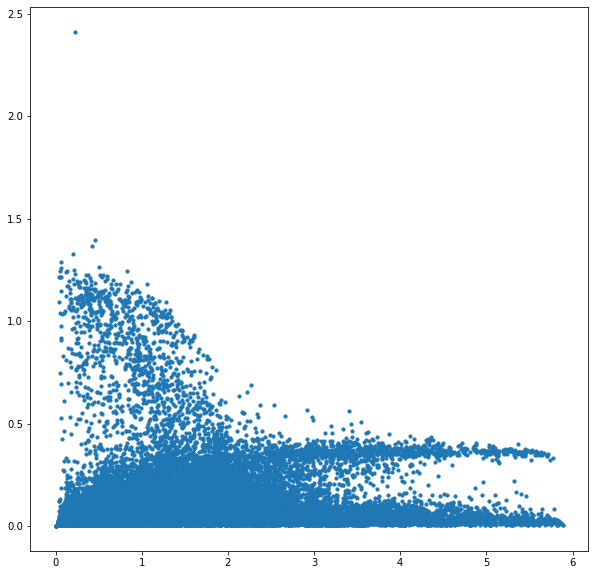

In [112]:
plt.figure(figsize=[10,10])
plt.scatter(cat.z500, ((cat.z840 - cat.z160)/2) / (1+cat.z500), s=10)

/Users/felix/anaconda3/envs/grizli/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/felix/anaconda3/envs/grizli/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/felix/anaconda3/envs/grizli/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot`

(-0.05, 0.6)

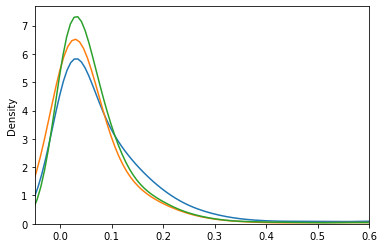

In [113]:
sea.distplot(((cat.query('1 < z500 < 1.2').z840 - cat.query('1 < z500 < 1.2').z160)/2) /\
             (1+cat.query('1 < z500 < 1.2').z500), hist = False)

sea.distplot(((cat.query('0.5 < z500 < 0.7').z840 - cat.query('0.5 < z500 < 0.7').z160)/2) /\
             (1+cat.query('0.5 < z500 < 0.7').z500), hist = False)

sea.distplot(((cat.query('0.7 < z500 < 1').z840 - cat.query('0.7 < z500 < 1').z160)/2) /\
             (1+cat.query('0.7 < z500 < 1').z500), hist = False)

plt.xlim(-0.05, 0.6)

In [114]:
lims = np.arange(0.2, 3, 0.1)

DZ = []
MZ = []

for i in range(len(lims)-1):
    DZ.append(np.median(((cat.query('{} < z500 < {}'.format(lims[i], lims[i] + 0.1)).z840 -\
      cat.query('{} < z500 < {}'.format(lims[i], lims[i] + 0.1)).z160)/2) /\
             (1+cat.query('{} < z500 < {}'.format(lims[i], lims[i] + 0.1)).z500)))
    MZ.append(lims[i] + 0.05)

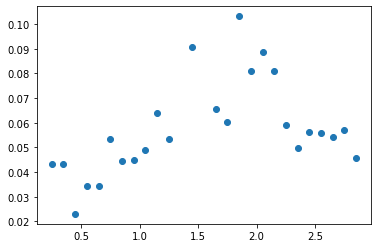

In [115]:
plt.scatter(MZ, DZ)